## Text-to-Image Classifier with Attention Mechanisms Inspired by Auditory Perception
### Ben Richardson and Kendra Noneman
CMU 10-701: Introduction to Machine Learning (Fall 2022)

This notebook shows our workflow trying to implement an audio extension onto the multimodal text-to-image CLIP classification model. The logic behind our project proposal was flawed, but we finished the implementation to show how and why it didn't work. 

In our report, we then compare this work to a successful and optimized 'AudioCLIP' model which expands the capabilities of CLIP to incoporate audio as well. We explain why their method worked and ours didn't, and compare the performance of AudioCLIP to the baseline functionality of Clip. 

In [1]:
# Import all packages/toolboxes

from PIL import Image
from matplotlib.pyplot import imshow
import requests
import torch
import numpy as np
import pandas as pd
import math
from gtts import gTTS
import matplotlib.pyplot as plt
import seaborn as sns
from playsound import playsound
from audio2numpy import open_audio
import ffmpeg
import librosa
from scipy.signal import butter,filtfilt,find_peaks,stft
from scipy.fft import fft
import pyttsx3
from scipy.io import wavfile
import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence
import IPython.display as ipd
from scipy.fftpack import dct

from gtts import gTTS 
from gtts.tokenizer.pre_processors import abbreviations, end_of_line 
from pygame import mixer  
from pydub import AudioSegment 
import time 

%matplotlib inline

# Library documentation: https://huggingface.co/docs/transformers/model_doc/clip
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, CLIPImageProcessor

pygame 2.1.2 (SDL 2.0.18, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Show steps for simple example with one image
### (a) Load example image

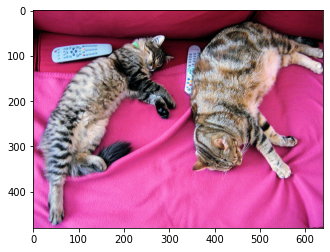

In [10]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
imshow(image)

### (c) Tokenize image label (before biasing with speech features)

In [2]:
model_name = "openai/clip-vit-base-patch32"

tokenizer = AutoTokenizer.from_pretrained(model_name)
image_label = "a photo of a cat"

encoding = tokenizer(image_label)
print(encoding)

{'input_ids': [49406, 320, 1125, 539, 320, 2368, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


### (d) Convert text to speech in .wav format

In [9]:
tts = gTTS(image_label, slow=False, tld='com.au', pre_processor_funcs = [abbreviations, end_of_line]) 
tts.save('image_sound.mp3')

sound = AudioSegment.from_mp3("image_sound.mp3")
sound.export("image_sound.wav", format="wav")

mixer.init()
mixer.music.load("image_sound.mp3")
mixer.music.play()
time.sleep(2)

### (e) Extract speech signal 

Shape         (14784,)
Seconds       1.848


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0.5, 0, 'Seconds')

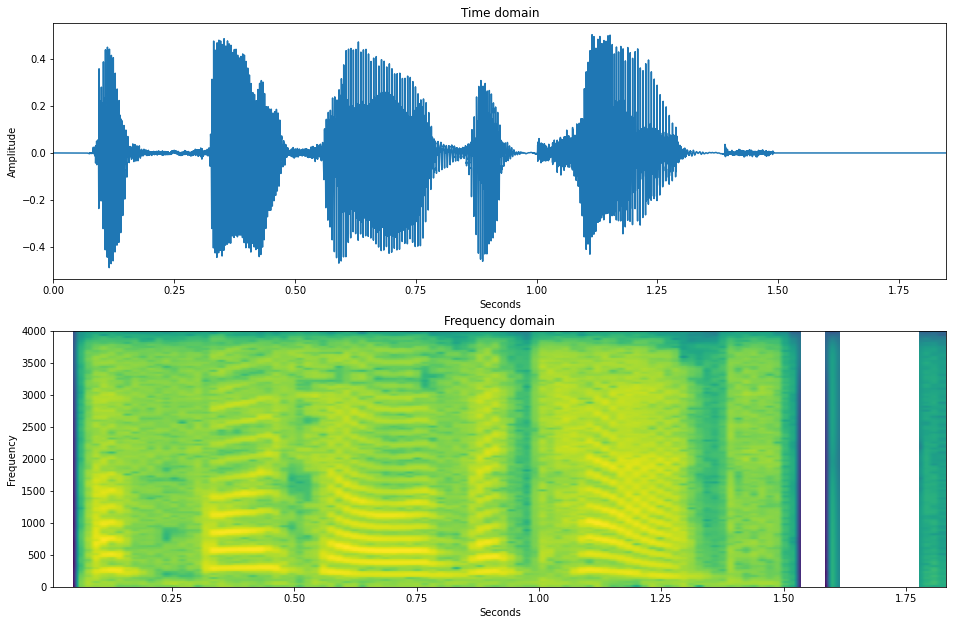

In [10]:
audio_file = "image_sound.wav"
ipd.Audio(audio_file)

sr, s = wavfile.read(audio_file)

samples, sample_rate = librosa.load(audio_file, mono=True, sr=8000)
print("Shape        ",samples.shape)
print("Seconds      ",samples.shape[0]/sample_rate)

sig = samples
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

### (f) Use Vocal Activity Detection (VAD) to remove parts of signal with no speech

Shape         (11000,)
Seconds       1.375


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


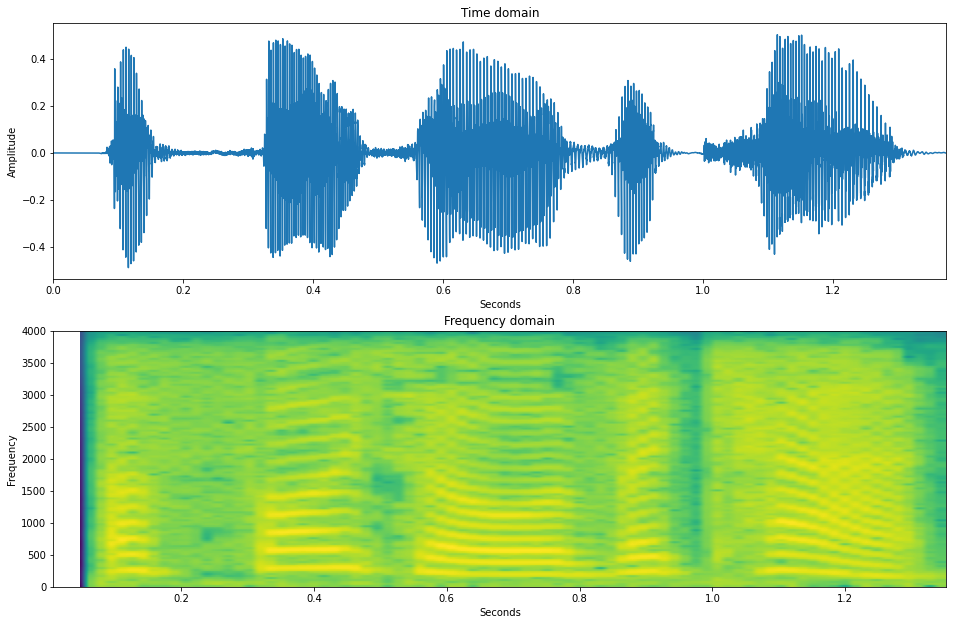

In [11]:
total_s = int(samples.shape[0]/1000)
vad_signal = []
for i in range(total_s):
    sig = samples[i*1000:(i+1)*1000]
    rms = math.sqrt(np.square(sig).mean())
    if(rms > 0.012):
        vad_signal = np.append(vad_signal,sig)
print("Shape        ",vad_signal.shape)
print("Seconds      ",vad_signal.shape[0]/sample_rate)


#plot_signal(vad_signal,sample_rate)
sig = vad_signal
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

sf.write('vad_signal.wav', vad_signal, sample_rate, subtype='PCM_16')
ipd.Audio('vad_signal.wav')

### (g) Use pre-emphasis filter to flatten spectrum of signal

Shape         (11000,)
Seconds       1.375


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


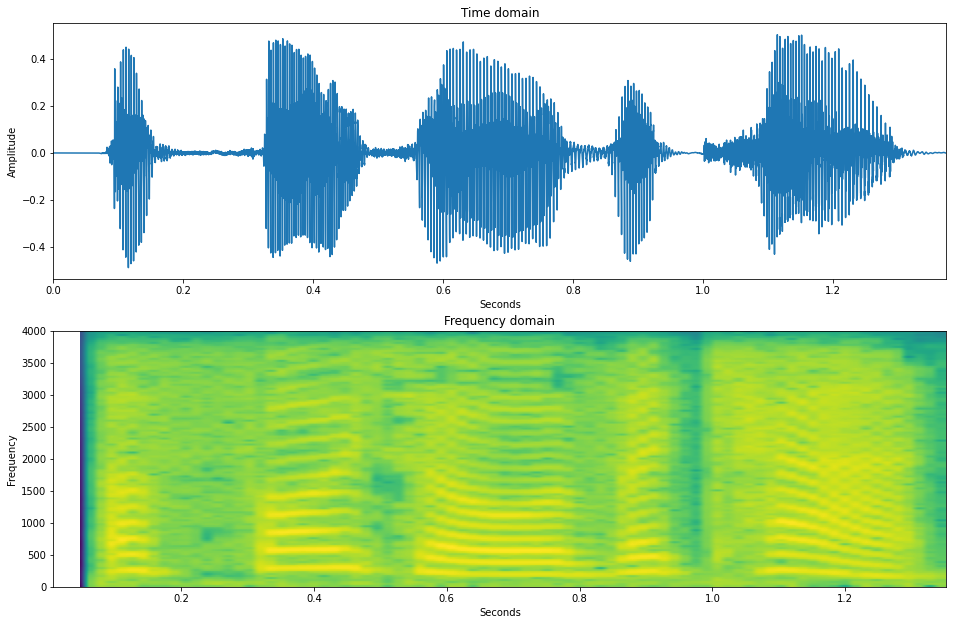

In [12]:
emph_signal = np.append(vad_signal[0], vad_signal[1:] - 0.95 * vad_signal[:-1])
print("Shape        ",emph_signal.shape)
print("Seconds      ",emph_signal.shape[0]/sample_rate)

    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

sf.write('emph_signal.wav', emph_signal, sample_rate, subtype='PCM_16')
ipd.Audio('emph_signal.wav')

### (h) Find the peaks of signal, ideally pulling out each word

[0.413535   0.32769743 0.40839255 0.36198118 0.60436517]


(0.0, 1.374875)

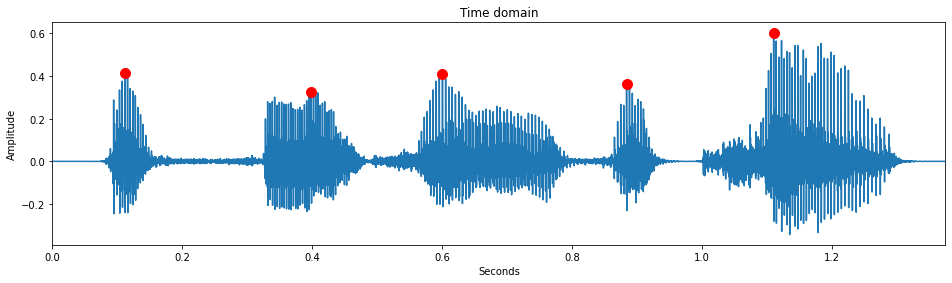

In [16]:
peaks, _ = find_peaks(emph_signal,prominence=0.5,distance=1500)
ids_scale = emph_signal[peaks]
print(ids_scale)

sig = emph_signal
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.plot(peaks/sr, emph_signal[peaks], "ro", markersize=10)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])


### (i) Use signal peaks to bias the attention mask of the text tokenizer

In [17]:
model_name = "openai/clip-vit-base-patch32"

tokenizer = AutoTokenizer.from_pretrained(model_name)
image_label = "a photo of a cat"

encoding = tokenizer(image_label)
print(encoding)

# Use ids_scale to change the attention mask



{'input_ids': [49406, 320, 1125, 539, 320, 2368, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Show how the image-text similarity score and label probabilities changed when scaling attention_mask

# Based on how strongly you change the attention mask using ids_scale, how does the image-text similarity and label probabilities change?
# Loop through different strengths of scaling the attention mask 2*ids_scale, 3*ids_scale, etc.... 
# Normalize after each iteration so the mask still ranges from 0 - 1


# Plot something like label-probabilities v. scaling factor for a few thousand iterations

# For each iteration, measure how long it took to process as well 
# Plot time to calculate image-text similarity v. scaling factor 



In [21]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#print(model)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print(processor)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(probs)

CLIPProcessor:
- feature_extractor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: PreTrainedTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_len=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': Adde

In [ ]:

# Find the n words with largest auditory cue, and then set the attention mask to 1 only for those words
#print(normalized_heights_cat)
#np.random.shuffle(normalized_heights_cat)
#np.random.shuffle(normalized_heights_dog)
#print(normalized_heights_cat)

attention_mask_cat = np.concatenate([np.ones(1),heights_cat,np.ones(1)])
attention_mask_dog = np.concatenate([np.ones(1),heights_dog,np.ones(1)])
print(attention_mask_cat)
print(attention_mask_dog)
print(4000*attention_mask_cat)

inputs["attention_mask"] = torch.Tensor([4000*attention_mask_cat,4000*attention_mask_dog])
#inputs["attention_mask"] = torch.Tensor([[1,1,1,1,1,1,1],[1,1,1,1,1,1,1]])

#torch.Tensor([np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist(),np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist()])
#print(np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist())





In [3]:
def audio_sig(image_label):

    tts = gTTS(image_label, slow=False, tld='com.au', pre_processor_funcs = [abbreviations, end_of_line]) 
    tts.save('image_sound.mp3')

    sound = AudioSegment.from_mp3("image_sound.mp3")
    sound.export("image_sound.wav", format="wav")

    audio_file = "image_sound.wav"
    ipd.Audio(audio_file)

    sr, s = wavfile.read(audio_file)

    samples, sample_rate = librosa.load(audio_file, mono=True, sr=8000)

    total_s = int(samples.shape[0]/1000)
    vad_signal = []
    for i in range(total_s):
        sig = samples[i*1000:(i+1)*1000]
        rms = math.sqrt(np.square(sig).mean())
        if(rms > 0.012):
            vad_signal = np.append(vad_signal,sig)

    emph_signal = np.append(vad_signal[0], vad_signal[1:] - 0.95 * vad_signal[:-1])

    peaks, _ = find_peaks(emph_signal,prominence=0.5,distance=1500)
    ids_scale = emph_signal[peaks]

    return ids_scale

In [8]:
cat_ids = audio_sig("a photo of a cat")
print(test_ids)

dog_ids = audio_sig("a photo of a dog")
print(dog_ids)

[0.413535   0.32736391 0.40839255 0.36198118 0.60436517]
[0.413535   0.32589037 0.40777738 0.38984019]
